In [1]:
!pip install optuna
!pip install xgboost

In [3]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score,average_precision_score,make_scorer, f1_score
from sklearn.calibration import calibration_curve
from sklearn.model_selection import cross_val_score,StratifiedKFold

In [38]:
df=pd.read_csv("C:/Users/paulm/Downloads/nationalhealthsurvgey/final_health_dataset.csv")
df.head()
df.info()

C:\Users\paulm\AppData\Local\Temp\ipykernel_23036\1788823258.py:1: DtypeWarning: Columns (1505) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("C:/Users/paulm/Downloads/nationalhealthsurvgey/final_health_dataset.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8748 entries, 0 to 8747
Columns: 1704 entries, SEQN to Poor_Sleep
dtypes: bool(48), float64(1619), int64(28), object(9)
memory usage: 110.9+ MB


In [40]:
df[['DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TFIBE', 'DR1TSFAT',
    'DR1TCHOL', 'DR1TSUGR', 'DR1TSODI',
    'PAQ605', 'PAQ620', 'PAD615', 'PAD630']]

,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TFIBE,DR1TSFAT,DR1TCHOL,DR1TSUGR,DR1TSODI,PAQ605,PAQ620,PAD615,PAD630
0,1574.000000,43.630000,239.590000,10.800000,17.819000,209.000000,176.470000,1323.000000,2.0,2.0,186.613896,152.305804
1,5062.000000,338.130000,423.780000,16.700000,53.408000,2584.000000,44.990000,9726.000000,2.0,1.0,186.613896,10.000000
2,1743.000000,64.610000,224.390000,9.900000,25.263000,88.000000,102.900000,2943.000000,2.0,1.0,186.613896,30.000000
3,1490.000000,77.750000,162.920000,10.600000,23.511000,187.000000,80.580000,2745.000000,2.0,2.0,186.613896,152.305804
4,1421.000000,55.240000,178.200000,12.300000,4.479000,41.000000,87.780000,797.000000,2.0,1.0,186.613896,30.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
8743,2033.123376,77.542804,250.469446,15.918847,25.407269,274.089189,111.248786,3328.382869,2.0,2.0,186.613896,152.305804
8744,4687.000000,223.320000,494.540000,30.400000,80.414000,794.000000,160.630000,8043.000000,2.0,2.0,186.613896,152.305804
8745,2475.000000,89.370000,290.370000,25.700000,29.372000,171.000000,126.540000,5468.000000,2.0,2.0,186.613896,152.305804
8746,2033.123376,77.542804,250.469446,15.918847,25.407269,274.089189,111.248786,3328.382869,2.0,2.0,186.613896,152.305804


In [42]:
df[['MCQ160A','MCQ160B','MCQ160C','MCQ160D','MCQ160E','MCQ160F','MCQ160G']]

,MCQ160A,MCQ160B,MCQ160C,MCQ160D,MCQ160E,MCQ160F,MCQ160G
0,1.0,2.0,2.0,2.0,2.0,1.0,2.0
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,1.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...
8743,2.0,2.0,2.0,2.0,2.0,2.0,2.0
8744,2.0,2.0,2.0,2.0,2.0,2.0,2.0
8745,2.0,2.0,2.0,2.0,2.0,2.0,2.0
8746,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [44]:
df['hypertension'].dtype


dtype('O')

In [46]:
#cleaning the heart disease columns

# Define heart disease columns
heart_col = ['MCQ160A', 'MCQ160B', 'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ160G']

#Apply encoding only if column exists
for col in heart_col:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: 1 if x == 1 else 0 if x == 2 else np.nan)


df['Heart_Disease'] = df[heart_col].max(axis=1)

#Now check result
print(df['Heart_Disease'].value_counts(dropna=False))


Heart_Disease
0.0    7002
1.0    1746
Name: count, dtype: int64


In [48]:
#cleaning physical activity columns

physical_col=['PAQ605', 'PAQ620']
for col in physical_col:
  df[col]=df[col].apply(lambda x: 1 if x==1 else 0 if x==2 else np.nan)
df = df.dropna(subset=physical_col)
df['PAQ605'].value_counts(dropna=False)
df['PAQ620'].value_counts(dropna=False)

PAQ620
0.0    6497
1.0    2248
Name: count, dtype: int64

In [50]:
#medication count
df['Medication_Count'] = df['RXDDRUG'].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)

In [52]:
#Feature Selection
desired_features = [
    'RIDAGEYR','age_group','RIAGENDR', 'RIDRETH1',
    'BMXBMI', 'bmi_Category', 'BPXSY1', 'BPXDI1', 'hypertension',
    'Smoker', 'Alcoholic', 'Poor_Sleep',
    'Medication_Count',
    'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TFIBE', 'DR1TSFAT',
    'DR1TCHOL', 'DR1TSUGR', 'DR1TSODI',
    'PAQ605', 'PAQ620', 'PAD615', 'PAD630'
]

# Filter columns that exist in the DataFrame
selected_features = [col for col in desired_features if col in df.columns]

# Define X and y
X = df[['RIDAGEYR','age_group','RIAGENDR', 'RIDRETH1',
    'BMXBMI', 'bmi_category', 'BPXSY1', 'BPXDI1', 'hypertension',
    'Smoker', 'Alcoholic', 'Poor_Sleep',
    'Medication_Count',
    'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TFIBE', 'DR1TSFAT',
    'DR1TCHOL', 'DR1TSUGR', 'DR1TSODI',
    'PAQ605', 'PAQ620', 'PAD615', 'PAD630']]
y = df['Heart_Disease']
X=pd.get_dummies(X,drop_first=True)

# BASE-LINE MODEL ***LogisticRegression***

In [55]:

#splitting data and training

X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=42,test_size=0.2)
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='saga',tol=1e-4 ,max_iter=10000, class_weight='balanced')
)
pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)
y_prob=pipeline.predict_proba(X_test)[:,1]
print("accuracy:",accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Precision_recall_AUC:", average_precision_score(y_test, y_prob))

accuracy: 0.8324757004002287
[[1156  244]
 [  49  300]]
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89      1400
         1.0       0.55      0.86      0.67       349

    accuracy                           0.83      1749
   macro avg       0.76      0.84      0.78      1749
weighted avg       0.88      0.83      0.84      1749

ROC AUC Score: 0.9263896848137536
Precision_recall_AUC: 0.7454384342370393


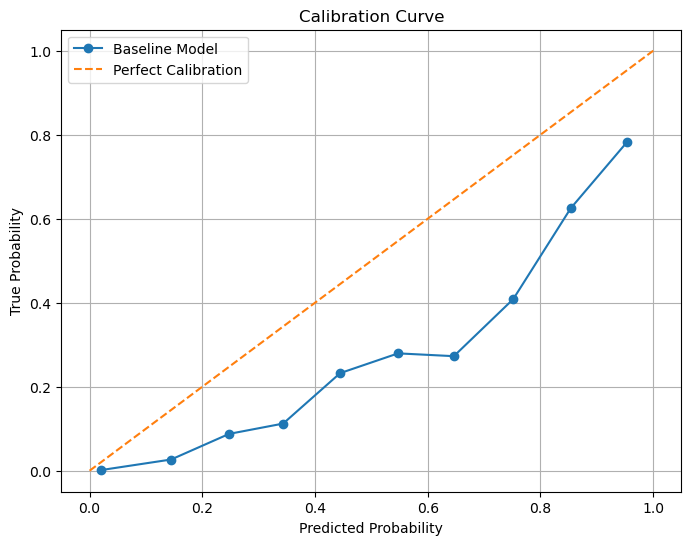

In [57]:

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Baseline Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#MODEL WITHOUT PENALTY
# Objective function to optimize
def objective(trial):
    # Define search space
    C = trial.suggest_float("C", 0.01, 10.0, log=True)
    solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs"])
    # Define pipeline
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            C=C,

            solver=solver,
            max_iter=1000,
            class_weight='balanced'
        )
    )

    # 5-fold CV, using F1-score for heart disease detection
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)

    return score.mean()

# Create Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # You can increase to 50 or 100 for better results

# Best parameters
print("✅ Best trial parameters:")
print(study.best_trial.params)

# Final best model
best_C = study.best_trial.params['C']
best_solver = study.best_trial.params['solver']

# Retrain best model on full training set
from sklearn.pipeline import make_pipeline
best_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=best_C,

        solver=best_solver,
        max_iter=1000,
        class_weight='balanced'
    )
)

best_pipeline.fit(X_train, y_train)



y_pred = best_pipeline.predict(X_test)
y_prob=best_pipeline.predict_proba(X_test)[:,1]
print("accuracy:",accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Precision_recall_AUC:", average_precision_score(y_test, y_prob))

[I 2025-06-18 10:34:43,072] A new study created in memory with name: no-name-35843521-102c-4555-a16a-b625cac5fbcc
[I 2025-06-18 10:34:45,111] Trial 0 finished with value: 0.6782435155279529 and parameters: {'C': 0.09004358490142975, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.6782435155279529.
[I 2025-06-18 10:34:45,487] Trial 1 finished with value: 0.6739139372951287 and parameters: {'C': 5.322675615863844, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6782435155279529.
[I 2025-06-18 10:34:45,680] Trial 2 finished with value: 0.6731239240401539 and parameters: {'C': 0.016313477431709876, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6782435155279529.
[I 2025-06-18 10:34:46,006] Trial 3 finished with value: 0.6739139372951287 and parameters: {'C': 3.184679118741156, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6782435155279529.
[I 2025-06-18 10:34:46,278] Trial 4 finished with value: 0.6754002705862032 and parameters: {'C': 0.36497010707516625, 'solver': 

✅ Best trial parameters:
{'C': 0.09004358490142975, 'solver': 'lbfgs'}
accuracy: 0.8319039451114922
[[1156  244]
 [  50  299]]
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89      1400
         1.0       0.55      0.86      0.67       349

    accuracy                           0.83      1749
   macro avg       0.75      0.84      0.78      1749
weighted avg       0.88      0.83      0.84      1749

ROC AUC Score: 0.9260744985673353
Precision_recall_AUC: 0.7448635663474372


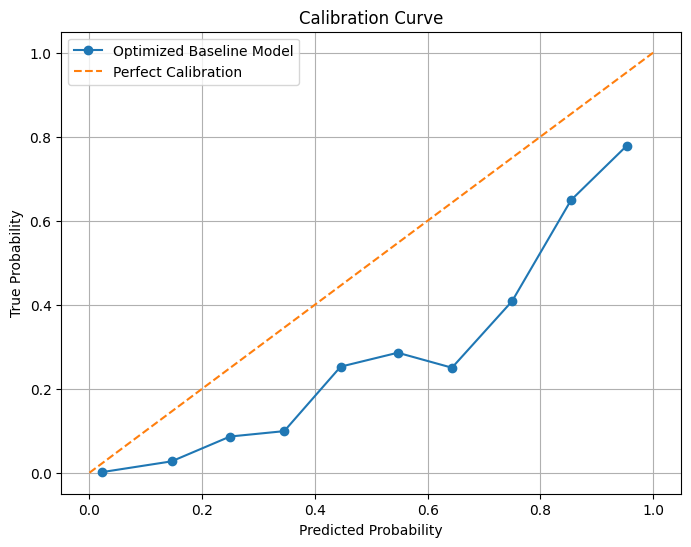

In [ ]:
y_prob=best_pipeline.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Optimized Baseline Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#MODEL WITH PENALTY
def objective(trial):
    # Suggest hyperparameters
    C = trial.suggest_float('C', 1e-3, 1e2, log=True)

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = 'liblinear' if penalty == 'l1' else trial.suggest_categorical('solver', ['lbfgs', 'saga'])
    #solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    # Define pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            class_weight=class_weight,
            max_iter=1000
        ))
    ])

    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipeline, X, y, scoring='recall', cv=skf, n_jobs=-1).mean()

    return score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # You can increase trials for better tuning
print("Best trial:")
print(study.best_trial)

# Best params
best_params = study.best_params
print("\nBest Hyperparameters:", best_params)

# Retrain best model on full training set
from sklearn.pipeline import Pipeline

best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        C=best_params['C'],
        penalty=best_params['penalty'],
        solver=best_params['solver'] if best_params['penalty'] == 'l2' else 'liblinear',
        class_weight=best_params['class_weight'],
        max_iter=1000
    ))
])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_prob=best_model.predict_proba(X_test)[:,1]


print("\n Classification Report (Best Optuna Model):")
print("accuracy:",accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Precision_recall_AUC:", average_precision_score(y_test, y_prob))


[I 2025-06-18 08:55:09,869] A new study created in memory with name: no-name-532490e3-c2bb-4fa6-b91d-cfcb67135860
[I 2025-06-18 08:55:11,400] Trial 0 finished with value: 0.8681026249053122 and parameters: {'C': 0.5881067775457525, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8681026249053122.
[I 2025-06-18 08:55:11,812] Trial 1 finished with value: 0.5177683364621414 and parameters: {'C': 0.0022022696570352714, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.8681026249053122.
[I 2025-06-18 08:55:12,422] Trial 2 finished with value: 0.8681042716464118 and parameters: {'C': 51.78075907159151, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8681042716464118.
[I 2025-06-18 08:55:12,707] Trial 3 finished with value: 0.5401261403682113 and parameters: {'C': 0.0033388222327910273, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None}. Best is trial 2 with value: 0.8681042716464118.
[I 2025

Best trial:
FrozenTrial(number=29, state=1, values=[0.949538912492178], datetime_start=datetime.datetime(2025, 6, 18, 8, 56, 52, 245668), datetime_complete=datetime.datetime(2025, 6, 18, 8, 56, 52, 562428), params={'C': 0.0010081488795934204, 'penalty': 'l1', 'class_weight': 'balanced'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=100.0, log=True, low=0.001, step=None), 'penalty': CategoricalDistribution(choices=('l1', 'l2')), 'class_weight': CategoricalDistribution(choices=(None, 'balanced'))}, trial_id=29, value=None)

Best Hyperparameters: {'C': 0.0010081488795934204, 'penalty': 'l1', 'class_weight': 'balanced'}

 Classification Report (Best Optuna Model):
accuracy: 0.7478559176672385
[[972 428]
 [ 13 336]]
              precision    recall  f1-score   support

         0.0       0.99      0.69      0.82      1400
         1.0       0.44      0.96      0.60       349

    accuracy                           0.75      1749
   macr

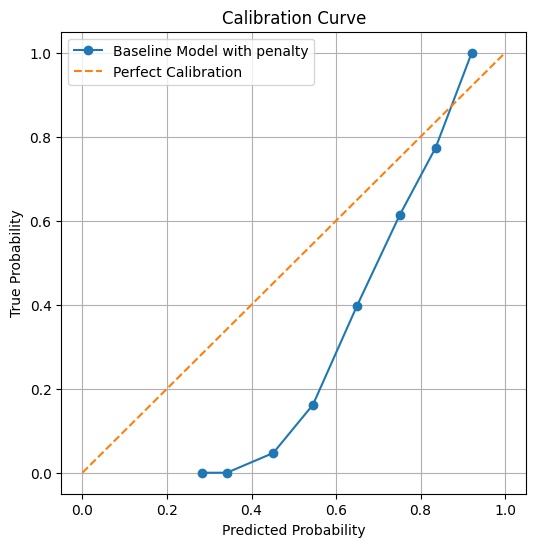

In [ ]:
y_prob=best_model.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Baseline Model with penalty')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

# ***XGBoost MODEL***

In [ ]:
#base XGBoost model

neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = neg / pos

# Build model
xgmodel = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,  #class weight not supported by xgboost
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgmodel.fit(X_train,y_train)
y_pred=xgmodel.predict(X_test)
y_prob=xgmodel.predict_proba(X_test)[:,1]
print("\n Classification Report (Best Optuna Model):")
print("accuracy:",accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Precision_recall_AUC:", average_precision_score(y_test, y_prob))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:55:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Classification Report (Best Optuna Model):
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      1400
         1.0       0.65      0.69      0.67       349

    accuracy                           0.86      1749
   macro avg       0.78      0.80      0.79      1749
weighted avg       0.87      0.86      0.86      1749

Accuracy: 0.8633504859919954
Confusion Matrix:
 [[1270  130]
 [ 109  240]]
ROC AUC Score: 0.7974109701187065
Precision_recall_AUC: 0.5083834344254953


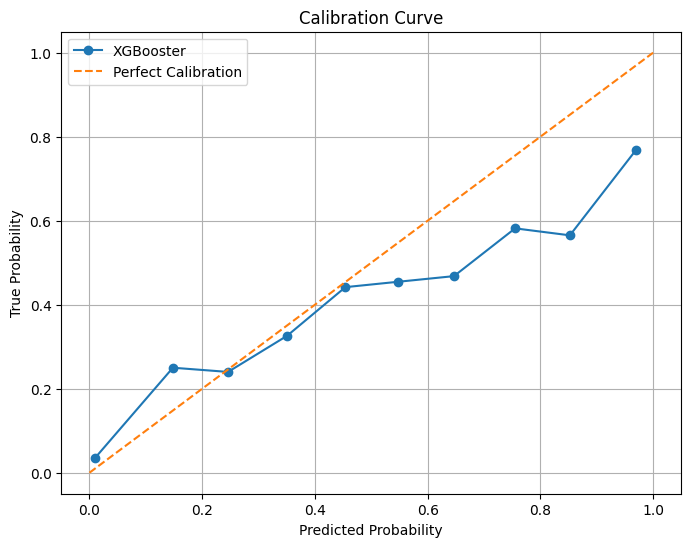

In [ ]:
y_prob=xgmodel.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='XGBooster')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#XGBoost with Optuna


# For handling imbalance
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_ratio = neg / pos

# Stratified K-Fold to preserve class balance in CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define objective function
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 4, 8),
        'gamma': trial.suggest_float('gamma', 1e-3, 1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', scale_ratio * 0.5, scale_ratio * 1.5),
        'eval_metric': 'logloss',
        'random_state': 42,
        'use_label_encoder': False,
    }

    model = XGBClassifier(**param)

    score = cross_val_score(
        model,
        X_train,
        y_train,
        scoring=make_scorer(f1_score),
        cv=skf,
        n_jobs=-1
    )

    return score.mean()

# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Print results
print("✅ Best Parameters:", study.best_trial.params)
print("✅ Best F1 Score:", study.best_value)

best_params = study.best_trial.params

xgb_best = XGBClassifier(
    **best_params,
    eval_metric='logloss',
    random_state=42
)

xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_test)
y_prob=xgb_best.predict_proba(X_test)[:,1]

print("accuracy:",accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Precision_recall_AUC:", average_precision_score(y_test, y_prob))


[I 2025-06-18 09:14:25,407] A new study created in memory with name: no-name-a18f6023-c679-4cb0-8cb5-7f9d52836832
[I 2025-06-18 09:14:45,928] Trial 0 finished with value: 0.6818363822173605 and parameters: {'n_estimators': 306, 'max_depth': 12, 'learning_rate': 0.01199092187816644, 'min_child_weight': 8, 'gamma': 0.03872951596861982, 'subsample': 0.6332680991615559, 'colsample_bytree': 0.7407712699150952, 'scale_pos_weight': 5.451204559370417}. Best is trial 0 with value: 0.6818363822173605.
[I 2025-06-18 09:14:50,591] Trial 1 finished with value: 0.6291712192220982 and parameters: {'n_estimators': 588, 'max_depth': 6, 'learning_rate': 0.2820964760563641, 'min_child_weight': 7, 'gamma': 0.13839790641831587, 'subsample': 0.6218241979971729, 'colsample_bytree': 0.9218656581777643, 'scale_pos_weight': 4.378224159500558}. Best is trial 0 with value: 0.6818363822173605.
[I 2025-06-18 09:14:59,501] Trial 2 finished with value: 0.6651553653557357 and parameters: {'n_estimators': 705, 'max_dep

✅ Best Parameters: {'n_estimators': 374, 'max_depth': 11, 'learning_rate': 0.012969082265451707, 'min_child_weight': 6, 'gamma': 0.0067395449115206785, 'subsample': 0.9452172480458384, 'colsample_bytree': 0.8407186082369162, 'scale_pos_weight': 4.739211695476707}
✅ Best F1 Score: 0.6880356694921999
accuracy: 0.8513436249285306
[[1205  195]
 [  65  284]]
              precision    recall  f1-score   support

         0.0       0.95      0.86      0.90      1400
         1.0       0.59      0.81      0.69       349

    accuracy                           0.85      1749
   macro avg       0.77      0.84      0.79      1749
weighted avg       0.88      0.85      0.86      1749

ROC AUC Score: 0.9226688497748669
Precision_recall_AUC: 0.7276860633270006


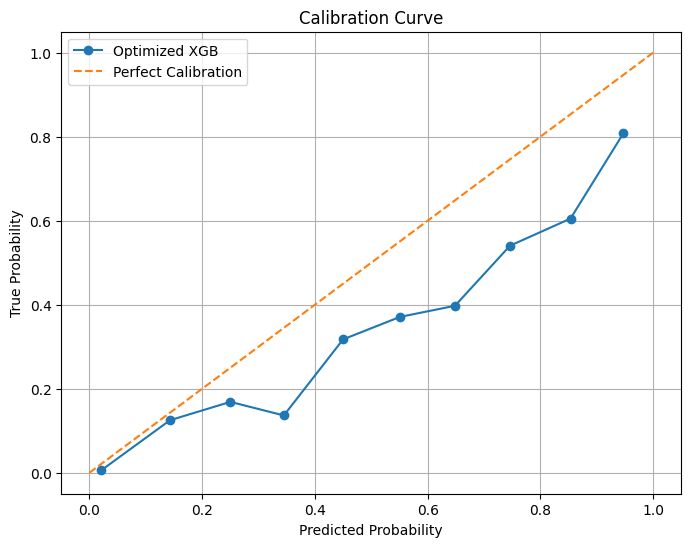

In [ ]:
y_prob=xgb_best.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Optimized XGB')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

# ***DEEP LEARNING MODEL***

In [59]:
!pip install tensorflow
!pip install keras-tuner --quiet
import numpy as np
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam,Nadam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, make_scorer

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [76]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weight_dict)

model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])


Class Weights: {0: 0.6245313336904125, 1: 2.50752688172043}


C:\Users\paulm\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [78]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    class_weight=class_weight_dict,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6654 - loss: 0.5790 - val_accuracy: 0.8200 - val_loss: 0.3774
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8112 - loss: 0.4024 - val_accuracy: 0.8279 - val_loss: 0.3805
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8118 - loss: 0.3835 - val_accuracy: 0.8271 - val_loss: 0.3714
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8219 - loss: 0.3558 - val_accuracy: 0.8229 - val_loss: 0.3716
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8186 - loss: 0.3603 - val_accuracy: 0.8186 - val_loss: 0.3803
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8292 - loss: 0.3455 - val_accuracy: 0.8243 - val_loss: 0.3753
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8237 - loss: 0.3568 - val_accuracy: 0.8264 - val_loss: 0.3620
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8241 - loss: 0.3483 - val_accuracy: 0.

In [88]:
# Predict
y_pred_probs = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_probs))
print("Precision-Recall AUC:", average_precision_score(y_test, y_pred_probs))


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8244711263579189
Confusion Matrix:
 [[1133  267]
 [  40  309]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.81      0.88      1400
         1.0       0.54      0.89      0.67       349

    accuracy                           0.82      1749
   macro avg       0.75      0.85      0.77      1749
weighted avg       0.88      0.82      0.84      1749

ROC AUC Score: 0.9207163323782235
Precision-Recall AUC: 0.7304913325814382


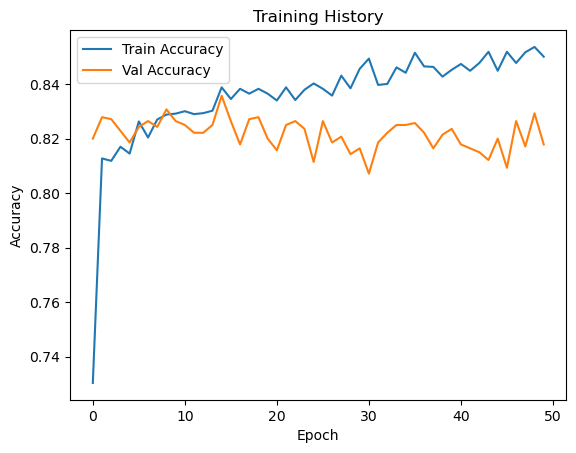

In [82]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


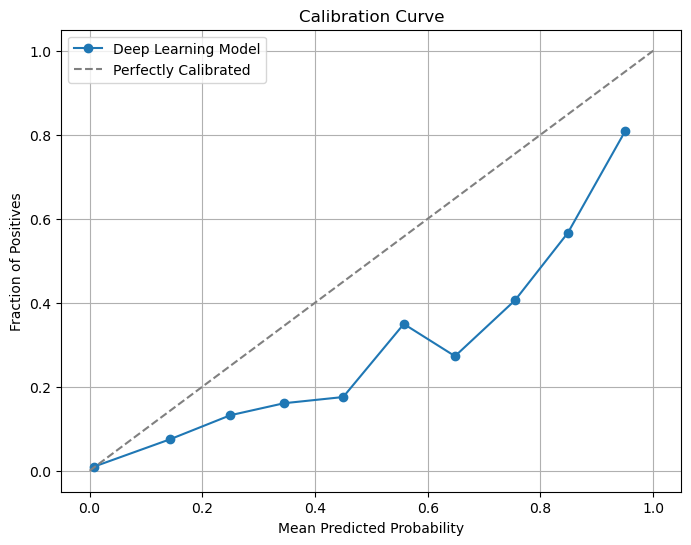

In [84]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_probs, n_bins=10, strategy='uniform')

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Deep Learning Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.title('Calibration Curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.grid()
plt.show()


In [65]:
# Imports
import numpy as np
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score


class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights_array))
print("Class Weights:", class_weight_dict)


#Build tunable model

def build_model(hp):
    model = Sequential()

    # First Dense Layer
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        input_shape=(X_train_scaled.shape[1],)
    ))
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    # Second Dense Layer
    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# -----------------------------------------------------------------------------------
# 3️⃣ Custom F1 Score Callback for better evaluation
# -----------------------------------------------------------------------------------
class F1Callback(Callback):
    def __init__(self, val_data):
        self.X_val, self.y_val = val_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        preds = (self.model.predict(self.X_val) > 0.5).astype("int32")
        f1 = f1_score(self.y_val, preds)
        self.f1_scores.append(f1)
        print(f"\n[Epoch {epoch + 1}] F1-score: {f1:.4f}")

# -----------------------------------------------------------------------------------
# 4️⃣ Split data for validation and tuning
# -----------------------------------------------------------------------------------
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

# -----------------------------------------------------------------------------------
# 5️⃣ Hyperparameter tuning with Keras Tuner (Hyperband)
# -----------------------------------------------------------------------------------
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',  # We monitor val_accuracy, but F1 is printed manually
    max_epochs=30,
    factor=3,
    directory='keras_tuner_dir',
    project_name='heart_disease_f1'
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
f1_callback = F1Callback(val_data=(X_val, y_val))

# Start tuning
tuner.search(
    X_subtrain, y_subtrain,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, f1_callback],
    verbose=1
)

# -----------------------------------------------------------------------------------
# 6️⃣ Evaluate best model on test data
# -----------------------------------------------------------------------------------
best_dl_model = tuner.get_best_models(num_models=1)[0]

# Predictions
y_pred_prob = best_dl_model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation
print("\n📊 Evaluation on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))
print("Precision-Recall AUC:", average_precision_score(y_test, y_pred_prob))


Class Weights: {0: 0.6245313336904125, 1: 2.50752688172043}
Reloading Tuner from keras_tuner_dir\heart_disease_f1\tuner0.json



C:\Users\paulm\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\paulm\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

📊 Evaluation on Test Set:
Accuracy: 0.8444825614636935
Confusion Matrix:
 [[1192  208]
 [  64  285]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      1400
         1.0       0.58      0.82      0.68       349

    accuracy                           0.84      1749
   macro avg       0.76      0.83      0.79      1749
weighted avg       0.88      0.84      0.85      1749

ROC AUC Score: 0.9235837085550553
Precision-Recall AUC: 0.7439980494412055


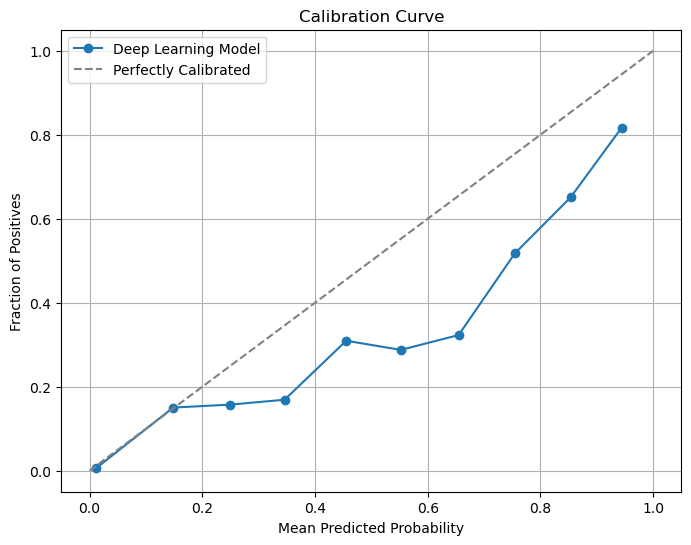

In [90]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10, strategy='uniform')

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Deep Learning Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.title('Calibration Curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.grid()
plt.show()

In [100]:
model.save("heart_disease_model.keras")

In [102]:
import os
os.getcwd()  # shows you the current folder path


'C:\\Users\\paulm\\Downloads'

In [108]:
import joblib
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [69]:
import json
with open("feature_columns.json", "w") as f:
    json.dump(list(X.columns), f)


# ***MODEL EXPLAINABILITY***

In [119]:
!pip install shap
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
shap.initjs()  # enables JS-based visualizations

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━

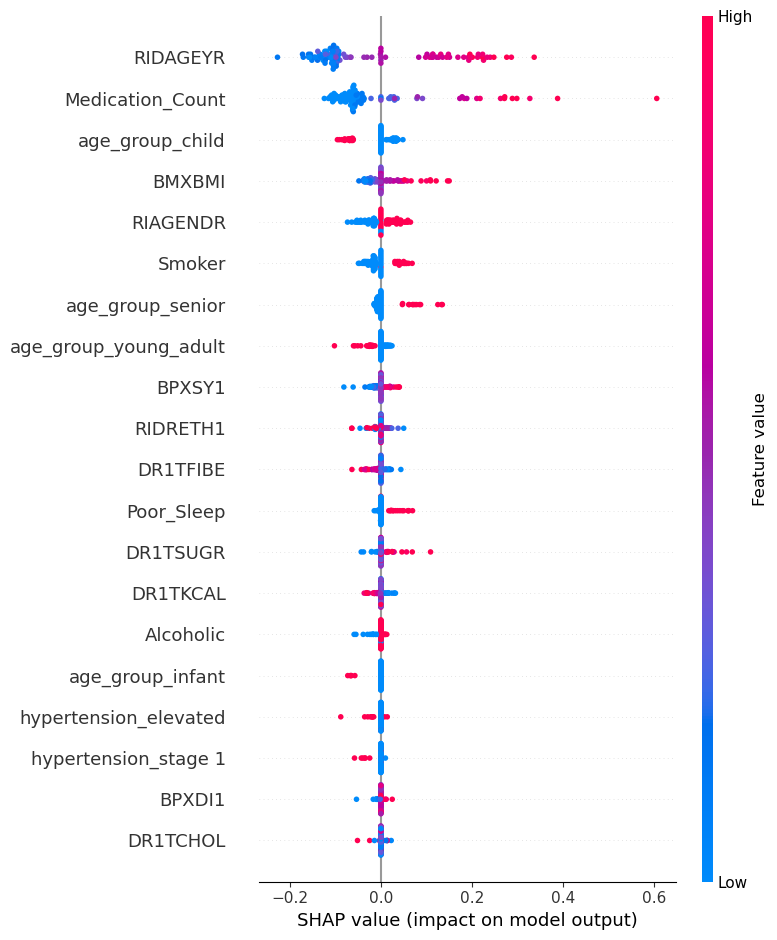

In [157]:
# Convert to DataFrame with column names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Sample for background and explanation
X_bg = X_test_scaled_df.sample(100, random_state=42)
X_subset = X_test_scaled_df.sample(100, random_state=1)

# Initialize KernelExplainer
explainer = shap.KernelExplainer(best_dl_model.predict, X_bg)

# Compute SHAP values (returns 3D: [samples, features, 1])
shap_values = explainer.shap_values(X_subset)

#Flatten to 2D
shap_values_2d = shap_values.squeeze(-1)

# Confirm shapes match
print("SHAP shape:", shap_values_2d.shape)
print("Data shape:", X_subset.shape)

# Summary plot for top 10 features
shap.summary_plot(shap_values_2d, X_subset, plot_type='dot') #max_display=10)

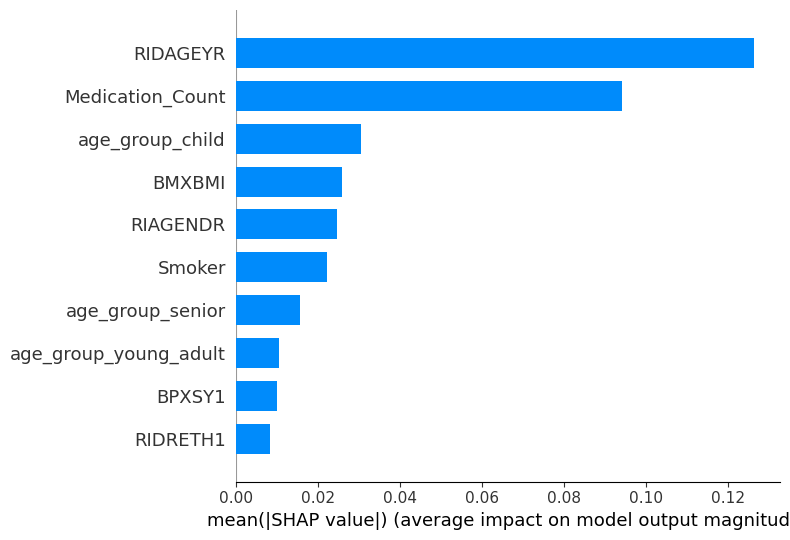

In [159]:
# Bar plot: average absolute SHAP value per feature
shap.summary_plot(shap_values_2d, X_subset, plot_type='bar', max_display=10)


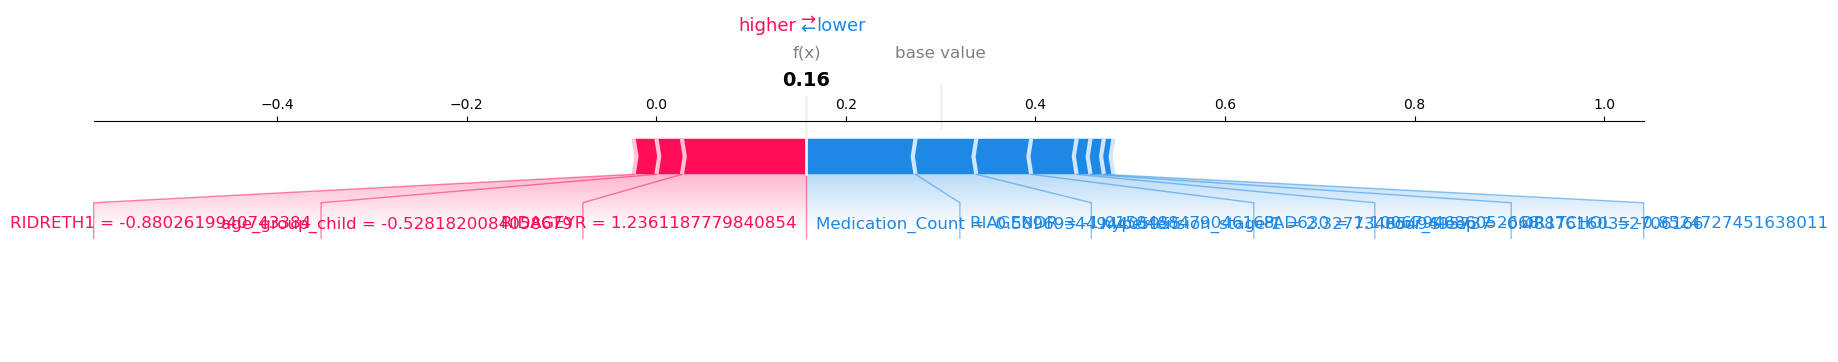

In [161]:
# Explain the 1st patient in X_subset
i = 0

shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values_2d[i],
    features=X_subset.iloc[i],
    feature_names=X_subset.columns,
    matplotlib=True  # For notebooks, not browser
)


In [71]:
# For up to 10 patients — in browser (JS)
shap.force_plot(
    explainer.expected_value,
    shap_values_2d[:10],   # explain 10 samples
    X_subset.iloc[:10],
    feature_names=X_subset.columns
)


NameError: name 'shap' is not defined